[View in Colaboratory](https://colab.research.google.com/github/AbhilashPal/Machine-Learning/blob/master/KaggleChallenges/NYCTaxi/XGBoost.ipynb)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#data dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,10]
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb

%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False


In [0]:
#authenticate

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
train_downloaded = drive.CreateFile({'id': '1TDx_ZFQgMjjAszmOFgFdzAWqMI2zT6ed'})
train_downloaded.GetContentFile('train.csv')
test_downloaded = drive.CreateFile({'id': '1KY8t31vdNC4OM9rkvnyREL9Vqc436Rh-'})
test_downloaded.GetContentFile('test.csv')  

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
df_train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [6]:
df_test.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N


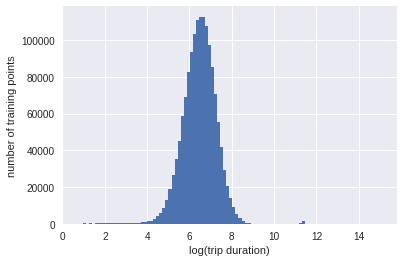

In [7]:
#data preprocessing

## how long is the avg trip 

df_train['log_trip_duration'] = np.log(df_train['trip_duration'].values + 1)
plt.hist(df_train['log_trip_duration'].values,bins=100)
plt.xlabel('log(trip duration)')
plt.ylabel('number of training points')
plt.show()

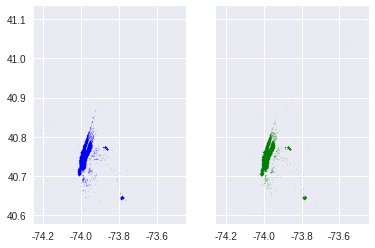

In [13]:
N = 10000
city_long_border = (-50,-50)
city_lat_border = (-40,-40)

fig,ax = plt.subplots(ncols=2,sharex=True,sharey=True)
ax[0].scatter(df_train['pickup_longitude'].values[:N],
             df_train['pickup_latitude'].values[:N],
             color = 'blue',s=1,label='train',alpha=0.1)

ax[1].scatter(df_test['pickup_longitude'].values[:N],
             df_test['pickup_latitude'].values[:N],
             color = 'green',s=1,label='train',alpha=0.1)

We plotted a map of Manhattan with the data!

In [0]:
#train model

features  = df_train[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']]
targets = df_train['trip_duration']

tfeatures = df_test[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']]


Xtr,Xts,Ytr,Yts = train_test_split(features,targets,test_size=0.2
                                  ,random_state = 1897)



In [21]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV

def rmsle(evaluator,X,real):
    sum = 0.0
    predicted = evaluator.predict(X)
    print("Number predicted less than 0: {}".format(np.where(predicted < 0)[0].shape))

    predicted[predicted < 0] = 0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p-r)**2
    return (sum/len(predicted))**0.5
  
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 100, 'seed':0, 'colsample_bytree': 1, 
             'max_depth': 7, 'min_child_weight': 1}


optimized_GBM = GridSearchCV(xgb.XGBRegressor(**ind_params), 
                             cv_params,scoring = rmsle, cv =4) 
optimized_GBM.fit(features, np.ravel(target))

Number predicted less than 0: (47,)
Number predicted less than 0: (44,)
Number predicted less than 0: (51,)
Number predicted less than 0: (46,)
Number predicted less than 0: (14,)
Number predicted less than 0: (21,)
Number predicted less than 0: (30,)
Number predicted less than 0: (18,)
Number predicted less than 0: (4,)
Number predicted less than 0: (8,)
Number predicted less than 0: (18,)
Number predicted less than 0: (4,)
Number predicted less than 0: (0,)
Number predicted less than 0: (1,)
Number predicted less than 0: (0,)
Number predicted less than 0: (1,)
Number predicted less than 0: (0,)
Number predicted less than 0: (1,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (2,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)


GridSearchCV(cv=4, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.01], 'subsample': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<function rmsle at 0x7f97bf232b70>, verbose=0)